# Data Analysis

The **Myers–Briggs Type Indicator (MBTI)** is an introspective self-report questionnaire indicating differing psychological preferences in how people perceive the world and make decisions. The test attempts to assign four categories:
- introversion (I) or extraversion (E),
- sensing (S) or intuition (N), 
- thinking (T) or feeling (F), 
- judging (J) or perceiving (P).

One letter from each category is taken to produce a four-letter test result, like "INFJ" or "ENFP".

Source : https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator
<br>Data source : https://www.kaggle.com/datasnaek/mbti-type

## Libraries

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import plotly.express as px
import re
import string
from wordcloud import WordCloud

## Data import

In [2]:
df = pd.read_csv('../mbti_data.csv')
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

## Data exploration

**Let's quickly analyze data quality.**

In [3]:
df.describe()

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'As much as I wish I could, I really don't.|||...
freq    1832                                                  1

The quality seems good, indeed: 
- no missing cells
- all MBTI types considered

**Let's see the distribution of the column 'type'.**

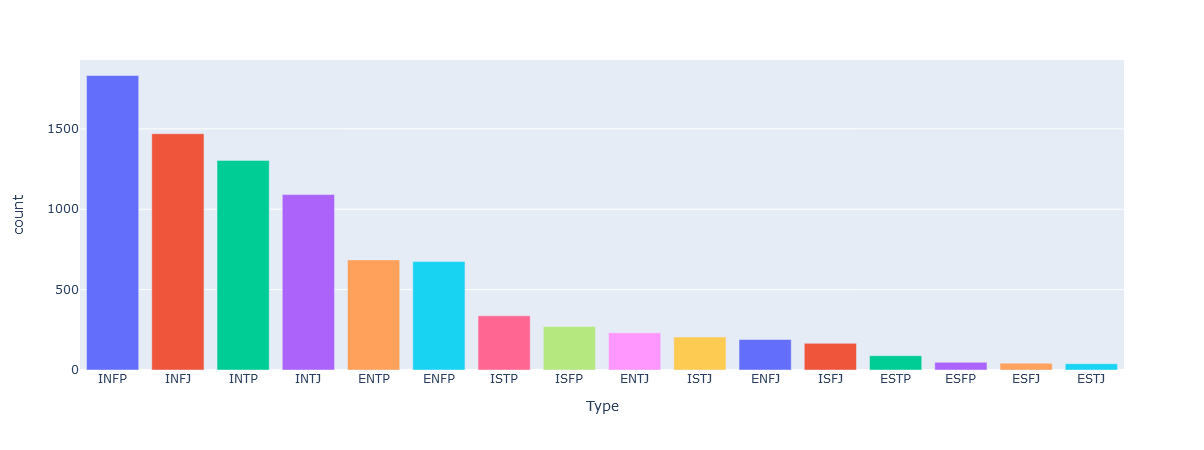

In [4]:
type_dist = df['type'].value_counts().rename_axis('types').reset_index(name='counts')

x = type_dist['types']
y = type_dist['counts']

fig = px.bar(x=x, y=y, labels={'x':'Type', 'y':'count'}, color=x)
fig.update_layout(showlegend=False)
fig.show()

The column "type" is unbalanced. 
<br>We will therefore use the metric "F1-score" instead of "accuracy" to evaluate our future classification model.

**Let's identify the most representative (most frequent) words of each MBTI type.**

First, we preprocess the posts.

In [5]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    return words

In [6]:
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

In [7]:
df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                       posts_preproc  
0  [http, www, youtub, com, watch, v, qsxhcwe3krw...  
1  [find, lack, post, alarm, sex, bore, posit, of...  
2  [good, one, http, www, youtub, com, watch, v, ...  
3  [dear, intp, enjoy, convers, day, esoter, gab,...  
4  [fire, anoth, silli, misconcept, approach, log...

Now we group all posts that are the same MBTI type.

In [8]:
df_grouped = df.groupby('type')['posts_preproc'].apply(list).reset_index(name='posts_grouped')
df_grouped['posts_grouped'] = df_grouped['posts_grouped'].apply(lambda row: [y for x in row for y in x]) # Flatten list
df_grouped

type                                      posts_grouped
0   ENFJ  [http, www, youtub, com, watch, v, plaaikvhvz,...
1   ENFP  [want, go, trip, without, stay, behind, option...
2   ENTJ  [fire, anoth, silli, misconcept, approach, log...
3   ENTP  [find, lack, post, alarm, sex, bore, posit, of...
4   ESFJ  [esfj, origin, mistyp, nfp, think, increasingl...
5   ESFP  [edit, forgot, board, current, read, artemi, f...
6   ESTJ  [catch, 22, although, quit, terribl, estj, fi,...
7   ESTP  [splinter, cell, blacklist, xbox, 360, estp, g...
8   INFJ  [http, www, youtub, com, watch, v, qsxhcwe3krw...
9   INFP  [think, agre, person, consid, alpha, beta, fox...
10  INTJ  [dear, intp, enjoy, convers, day, esoter, gab,...
11  INTP  [good, one, http, www, youtub, com, watch, v, ...
12  ISFJ  [love, feel, affection, one, love, care, care,...
13  ISFP  [paint, without, number, guess, istp, best, bu...
14  ISTJ  [newton, univers, graviti, law, mean, serious,...
15  ISTP  [got, 593, read, enneagram, 953, though, read,...

We select the 15 most frequent words for each type.

In [9]:
df_grouped['most_frequent_words_v1'] = df_grouped['posts_grouped'].apply(lambda row: Counter(row).most_common(15))
df_grouped

type                                      posts_grouped  \
0   ENFJ  [http, www, youtub, com, watch, v, plaaikvhvz,...   
1   ENFP  [want, go, trip, without, stay, behind, option...   
2   ENTJ  [fire, anoth, silli, misconcept, approach, log...   
3   ENTP  [find, lack, post, alarm, sex, bore, posit, of...   
4   ESFJ  [esfj, origin, mistyp, nfp, think, increasingl...   
5   ESFP  [edit, forgot, board, current, read, artemi, f...   
6   ESTJ  [catch, 22, although, quit, terribl, estj, fi,...   
7   ESTP  [splinter, cell, blacklist, xbox, 360, estp, g...   
8   INFJ  [http, www, youtub, com, watch, v, qsxhcwe3krw...   
9   INFP  [think, agre, person, consid, alpha, beta, fox...   
10  INTJ  [dear, intp, enjoy, convers, day, esoter, gab,...   
11  INTP  [good, one, http, www, youtub, com, watch, v, ...   
12  ISFJ  [love, feel, affection, one, love, care, care,...   
13  ISFP  [paint, without, number, guess, istp, best, bu...   
14  ISTJ  [newton, univers, graviti, law, mean, serious,...   
15  ISTP  [got, 593, read, enneagram, 953, though, read,...   

                               most_frequent_words_v1  
0   [(like, 1781), (think, 1410), (peopl, 1192), (...  
1   [(like, 6607), (think, 4686), (enfp, 4231), (p...  
2   [(like, 1882), (think, 1492), (entj, 1267), (p...  
3   [(like, 5911), (think, 4626), (entp, 3899), (p...  
4   [(like, 416), (esfj, 401), (think, 362), (peop...  
5   [(like, 392), (think, 295), (peopl, 226), (kno...  
6   [(like, 299), (think, 273), (estj, 240), (peop...  
7   [(like, 820), (think, 577), (estp, 565), (get,...  
8   [(like, 13081), (think, 10364), (peopl, 8657),...  
9   [(like, 17259), (think, 13133), (peopl, 10563)...  
10  [(like, 8690), (think, 6617), (intj, 6216), (p...  
11  [(like, 10783), (think, 8565), (peopl, 7149), ...  
12  [(like, 1552), (think, 1231), (isfj, 1071), (p...  
13  [(like, 2571), (think, 1791), (peopl, 1310), (...  
14  [(like, 1824), (think, 1241), (istj, 1077), (p...  
15  [(like, 2737), (think, 1994), (get, 1751), (pe...

In [10]:
for i in range(len(df_grouped)):
    print(f"{df_grouped['type'][i]}: \n{df_grouped['most_frequent_words_v1'][i]} \n")

ENFJ: 
[('like', 1781), ('think', 1410), ('peopl', 1192), ('enfj', 1147), ('feel', 1112), ('know', 1013), ('get', 942), ('realli', 901), ('one', 881), ('thing', 827), ('love', 796), ('would', 787), ('time', 770), ('person', 701), ('friend', 696)] 

ENFP: 
[('like', 6607), ('think', 4686), ('enfp', 4231), ('peopl', 3742), ('know', 3392), ('get', 3283), ('feel', 3238), ('one', 3232), ('realli', 3124), ('thing', 2927), ('love', 2919), ('time', 2722), ('would', 2675), ('go', 2302), ('make', 2278)] 

ENTJ: 
[('like', 1882), ('think', 1492), ('entj', 1267), ('peopl', 1239), ('get', 1096), ('one', 1054), ('would', 977), ('know', 958), ('type', 937), ('thing', 857), ('time', 812), ('make', 803), ('person', 788), ('feel', 776), ('say', 738)] 

ENTP: 
[('like', 5911), ('think', 4626), ('entp', 3899), ('peopl', 3739), ('one', 3277), ('get', 3129), ('know', 3002), ('would', 2685), ('thing', 2684), ('realli', 2590), ('time', 2402), ('type', 2260), ('go', 2182), ('make', 2161), ('say', 2145)] 

ESFJ

We notice that several words such as "like" and "think" are present for each type. Let's remove these words because they do not provide information for the next steps.

In [11]:
words_to_remove = [
    'like',
    'think',
    'peopl',
    'get',
    'know',
    'would',
    'realli',
    'time',
    'one',
    'well',
    'com',
    'www',
    'much',
    'say',
    'good',
    'someth',
    'thing',
    'way',
    'see',
    'want',
    'also',
    'type',
    'alway'
]

df_grouped['posts_grouped_filtered'] = df_grouped['posts_grouped'].apply(lambda row: [w for w in row if not w in words_to_remove])

In [12]:
df_grouped['most_frequent_words_v2'] = df_grouped['posts_grouped_filtered'].apply(lambda row: Counter(row).most_common(15))
df_grouped

type                                      posts_grouped  \
0   ENFJ  [http, www, youtub, com, watch, v, plaaikvhvz,...   
1   ENFP  [want, go, trip, without, stay, behind, option...   
2   ENTJ  [fire, anoth, silli, misconcept, approach, log...   
3   ENTP  [find, lack, post, alarm, sex, bore, posit, of...   
4   ESFJ  [esfj, origin, mistyp, nfp, think, increasingl...   
5   ESFP  [edit, forgot, board, current, read, artemi, f...   
6   ESTJ  [catch, 22, although, quit, terribl, estj, fi,...   
7   ESTP  [splinter, cell, blacklist, xbox, 360, estp, g...   
8   INFJ  [http, www, youtub, com, watch, v, qsxhcwe3krw...   
9   INFP  [think, agre, person, consid, alpha, beta, fox...   
10  INTJ  [dear, intp, enjoy, convers, day, esoter, gab,...   
11  INTP  [good, one, http, www, youtub, com, watch, v, ...   
12  ISFJ  [love, feel, affection, one, love, care, care,...   
13  ISFP  [paint, without, number, guess, istp, best, bu...   
14  ISTJ  [newton, univers, graviti, law, mean, serious,...   
15  ISTP  [got, 593, read, enneagram, 953, though, read,...   

                               most_frequent_words_v1  \
0   [(like, 1781), (think, 1410), (peopl, 1192), (...   
1   [(like, 6607), (think, 4686), (enfp, 4231), (p...   
2   [(like, 1882), (think, 1492), (entj, 1267), (p...   
3   [(like, 5911), (think, 4626), (entp, 3899), (p...   
4   [(like, 416), (esfj, 401), (think, 362), (peop...   
5   [(like, 392), (think, 295), (peopl, 226), (kno...   
6   [(like, 299), (think, 273), (estj, 240), (peop...   
7   [(like, 820), (think, 577), (estp, 565), (get,...   
8   [(like, 13081), (think, 10364), (peopl, 8657),...   
9   [(like, 17259), (think, 13133), (peopl, 10563)...   
10  [(like, 8690), (think, 6617), (intj, 6216), (p...   
11  [(like, 10783), (think, 8565), (peopl, 7149), ...   
12  [(like, 1552), (think, 1231), (isfj, 1071), (p...   
13  [(like, 2571), (think, 1791), (peopl, 1310), (...   
14  [(like, 1824), (think, 1241), (istj, 1077), (p...   
15  [(like, 2737), (think, 1994), (get, 1751), (pe...   

                               posts_grouped_filtered  \
0   [http, youtub, watch, v, plaaikvhvz, 51, went,...   
1   [go, trip, without, stay, behind, option, beli...   
2   [fire, anoth, silli, misconcept, approach, log...   
3   [find, lack, post, alarm, sex, bore, posit, of...   
4   [esfj, origin, mistyp, nfp, increasingli, comm...   
5   [edit, forgot, board, current, read, artemi, f...   
6   [catch, 22, although, quit, terribl, estj, fi,...   
7   [splinter, cell, blacklist, xbox, 360, estp, g...   
8   [http, youtub, watch, v, qsxhcwe3krw, http, 41...   
9   [agre, person, consid, alpha, beta, foxtrot, l...   
10  [dear, intp, enjoy, convers, day, esoter, gab,...   
11  [http, youtub, watch, v, fhigbolffgw, cours, b...   
12  [love, feel, affection, love, care, care, deep...   
13  [paint, without, number, guess, istp, best, bu...   
14  [newton, univers, graviti, law, mean, serious,...   
15  [got, 593, read, enneagram, 953, though, read,...   

                               most_frequent_words_v2  
0   [(enfj, 1147), (feel, 1112), (love, 796), (per...  
1   [(enfp, 4231), (feel, 3238), (love, 2919), (go...  
2   [(entj, 1267), (make, 803), (person, 788), (fe...  
3   [(entp, 3899), (go, 2182), (make, 2161), (feel...  
4   [(esfj, 401), (feel, 221), (love, 170), (make,...  
5   [(esfp, 184), (feel, 154), (person, 148), (htt...  
6   [(estj, 240), (person, 133), (feel, 129), (go,...  
7   [(estp, 565), (go, 312), (http, 287), (make, 2...  
8   [(infj, 8170), (feel, 7842), (person, 4907), (...  
9   [(feel, 10242), (infp, 9423), (http, 6862), (l...  
10  [(intj, 6216), (make, 3478), (feel, 3464), (ht...  
11  [(intp, 6400), (http, 4597), (feel, 4214), (ma...  
12  [(isfj, 1071), (feel, 777), (http, 585), (love...  
13  [(isfp, 1282), (feel, 1269), (http, 1192), (wa...  
14  [(istj, 1077), (feel, 735), (go, 717), (person...  
15  [(istp, 1598), (http, 1364), (go, 1154), (watc...

In [13]:
for i in range(len(df_grouped)):
    print(f"{df_grouped['type'][i]}: \n{df_grouped['most_frequent_words_v2'][i]} \n")

ENFJ: 
[('enfj', 1147), ('feel', 1112), ('love', 796), ('person', 701), ('friend', 696), ('make', 673), ('go', 664), ('thank', 515), ('http', 503), ('tri', 477), ('someon', 447), ('need', 432), ('lot', 411), ('use', 401), ('work', 379)] 

ENFP: 
[('enfp', 4231), ('feel', 3238), ('love', 2919), ('go', 2302), ('make', 2278), ('friend', 2241), ('person', 2061), ('http', 1694), ('thank', 1642), ('lot', 1611), ('tri', 1548), ('watch', 1380), ('even', 1354), ('look', 1325), ('use', 1301)] 

ENTJ: 
[('entj', 1267), ('make', 803), ('person', 788), ('feel', 776), ('go', 697), ('http', 610), ('work', 529), ('use', 506), ('tri', 501), ('friend', 474), ('need', 457), ('find', 455), ('love', 452), ('lot', 438), ('intj', 437)] 

ENTP: 
[('entp', 3899), ('go', 2182), ('make', 2161), ('feel', 2011), ('person', 1922), ('friend', 1689), ('http', 1638), ('use', 1603), ('love', 1528), ('tri', 1487), ('lot', 1375), ('work', 1309), ('actual', 1277), ('even', 1270), ('find', 1251)] 

ESFJ: 
[('esfj', 401), (

Finally, we plot the result.

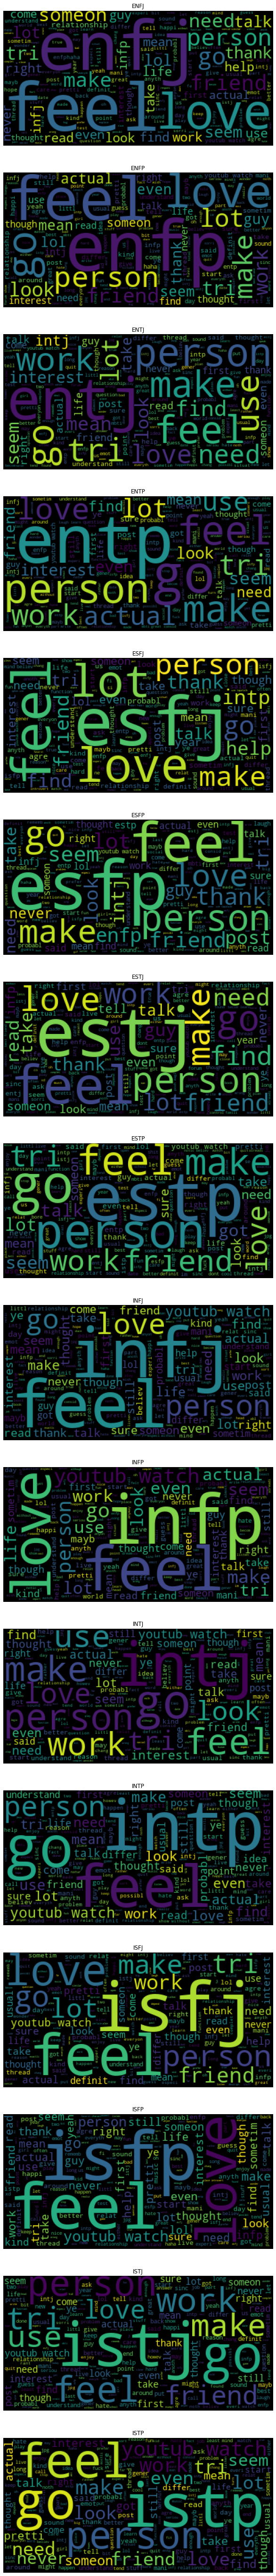

In [14]:
fig, ax = plt.subplots(len(df_grouped), figsize=(100,100))

for i in range(len(df_grouped)):
    wordcloud = WordCloud().generate(" ".join(df_grouped.loc[i, 'posts_grouped_filtered']))
    ax[i].imshow(wordcloud)
    ax[i].set_title(df_grouped.loc[i, 'type'])
    ax[i].axis("off")

## Data export

We remove the words identified as useless in the initial dataframe.

In [15]:
df['posts_preproc_filtered'] = df['posts_preproc'].apply(lambda row: [w for w in row if not w in words_to_remove])
df['posts_preproc_filtered_str'] = df['posts_preproc_filtered'].apply(lambda row: ' '.join(row))
df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                       posts_preproc  \
0  [http, www, youtub, com, watch, v, qsxhcwe3krw...   
1  [find, lack, post, alarm, sex, bore, posit, of...   
2  [good, one, http, www, youtub, com, watch, v, ...   
3  [dear, intp, enjoy, convers, day, esoter, gab,...   
4  [fire, anoth, silli, misconcept, approach, log...   

                              posts_preproc_filtered  \
0  [http, youtub, watch, v, qsxhcwe3krw, http, 41...   
1  [find, lack, post, alarm, sex, bore, posit, of...   
2  [http, youtub, watch, v, fhigbolffgw, cours, b...   
3  [dear, intp, enjoy, convers, day, esoter, gab,...   
4  [fire, anoth, silli, misconcept, approach, log...   

                          posts_preproc_filtered_str  
0  http youtub watch v qsxhcwe3krw http 41 media ...  
1  find lack post alarm sex bore posit often exam...  
2  http youtub watch v fhigbolffgw cours bless cu...  
3  dear intp enjoy convers day esoter gab natur u...  
4  fire anoth silli misconcept approach logic go ...

In [16]:
df = df.rename(columns={'posts_preproc_filtered_str': 'posts_final'})

In [18]:
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [17]:
df[['type', 'posts_final']].to_csv('../mbti_data_preproc.csv' ,index=False)